In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
import os
import pathlib

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
def get_img_lbl(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    label = int(one_hot)
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)
    # img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [64, 64])
    return img, label

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

In [3]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomRotation((-1/72,1/72)), # 360deg * [-1/72; 1/72] = [-5deg; 5deg] 
    keras.layers.RandomBrightness((-0.05,0.05)), # +-5%
    keras.layers.RandomContrast(0.05), # +-5%
    keras.layers.GaussianNoise(2.5), # 95% of samples fall between -2 * st_dev and +2 * st_dev => [-5; +5]
])

model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Resizing(64, 64),
    keras.layers.Rescaling(1./255,input_shape=(64, 64, 3)),
    keras.layers.Conv2D(128, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
 optimizer="sgd",
 metrics=["accuracy"], run_eagerly=True)

In [4]:
data_dir = pathlib.Path("./dataset/classification/")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in data_dir.glob('[A-D]*')]))
print(class_names)
list_ds = list_ds.repeat(50) # 20 * 50 = 1000 images of each traffic sign
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
train_ds = train_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

200
['A7' 'B2' 'B20' 'B33-30' 'B33-60' 'B36' 'B42' 'C12' 'D1' 'D6']
10000
8000
2000
Image shape:  (32, 64, 64, 1)
Label:  [[0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


In [19]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
250/250 [==============================] - 387s 2s/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 7.3968e-07 - val_accuracy: 1.0000
Epoch 2/30
250/250 [==============================] - 389s 2s/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 4.6372e-07 - val_accuracy: 1.0000
Epoch 3/30
250/250 [==============================] - 383s 2s/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 1.8001e-07 - val_accuracy: 1.0000
Epoch 4/30
250/250 [==============================] - 376s 2s/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 7.1048e-07 - val_accuracy: 1.0000
Epoch 5/30
250/250 [==============================] - 376s 2s/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 5.2925e-06 - val_accuracy: 1.0000
Epoch 6/30
250/250 [==============================] - 376s 2s/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 4.5001e-07 - val_accuracy: 1.0000
Epoch 7/30
250/250 [==============================] - 376s 2s/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 1.657

In [20]:
model.save('model_mono30.keras')

In [7]:
model = tf.keras.models.load_model('model_mono.keras')

In [8]:
test_list_ds = tf.data.Dataset.list_files('./dataset/classification/test/*/*.jpg')
print(len(test_list_ds))
test_ds = test_list_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
test_ds_copy = test_ds
test_ds = configure_for_performance(test_ds)

for image, label in test_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

model.evaluate(test_ds)

1039
Image shape:  (32, 64, 64, 1)
Label:  [[0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]

33/33 [==============================] - 16s 470ms/step - loss: 0.2059 - accuracy: 0.9615


[0.2058534026145935, 0.96150141954422]

In [9]:
from sklearn.metrics import confusion_matrix
# y_prediction = model.predict(test_ds)
# y_prediction = np.argmax(y_prediction, axis = 1)
# print(y_prediction,len(y_prediction))
y_test = []
x_test = []
for image, label in test_ds:
    y_test.append(label)
    x_test.append(image)
x_test = np.concatenate(x_test)
# print(x_test)
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test = np.concatenate(y_test)
y_test=np.argmax(y_test, axis=1)
# print(y_test,len(y_test))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

33/33 [==============================] - 15s 457ms/step
[[0.97005988 0.         0.00840336 0.         0.         0.
  0.04761905 0.         0.01449275 0.        ]
 [0.         0.91764706 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.05882353 0.98319328 0.         0.         0.02459016
  0.         0.         0.00724638 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.01694915 0.00724638 0.        ]
 [0.         0.01176471 0.         0.         0.85714286 0.
  0.         0.         0.         0.        ]
 [0.01197605 0.01176471 0.         0.         0.04761905 0.96721311
  0.         0.01694915 0.02173913 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.9047619  0.         0.         0.        ]
 [0.         0.         0.         0.         0.02380952 0.00819672
  0.         0.94915254 0.         0.        ]
 [0.01197605 0.         0.         0.         0.         0.
  0.

<Axes: >

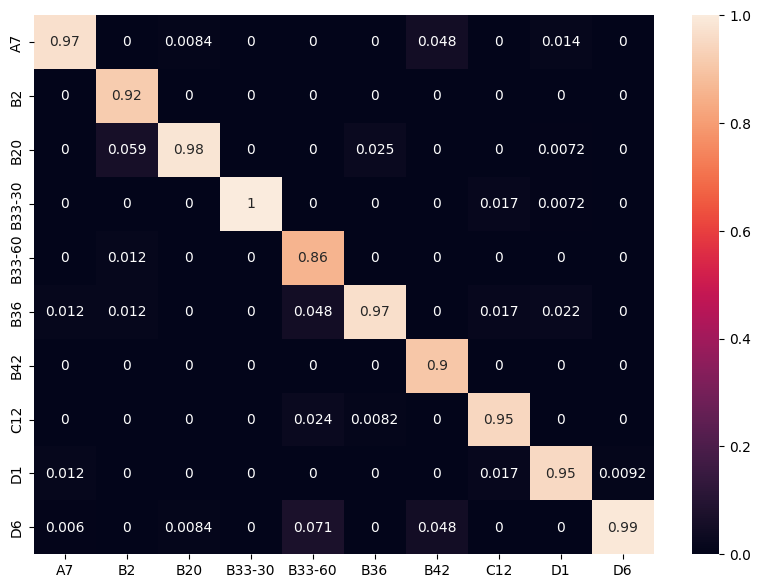

In [10]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(result, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

1/1 [==============================] - 1s 511ms/step
[4 5 2 9 5 3 8 6 9 0 1 0 0 5 2 5 9 9 6 4 9 8 8 3 0 2 5 0 9 0 4 9]


C:\Users\klaud\AppData\Local\Temp\ipykernel_26400\415358920.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


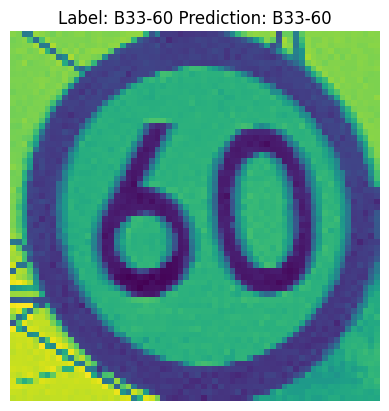

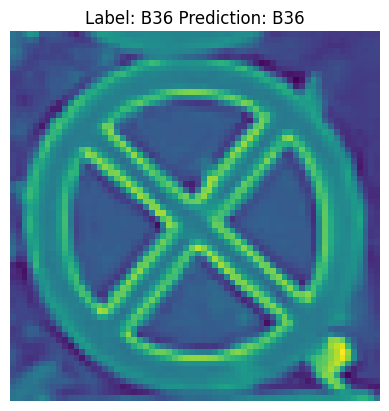

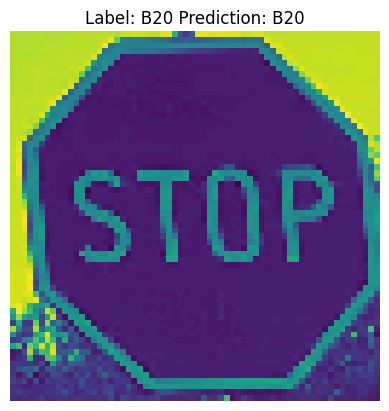

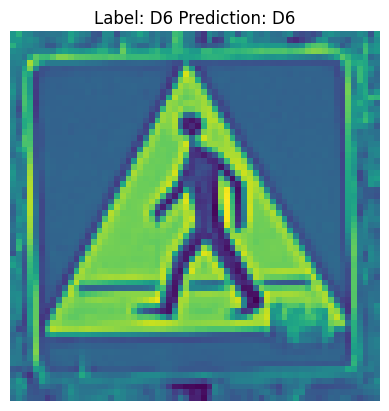

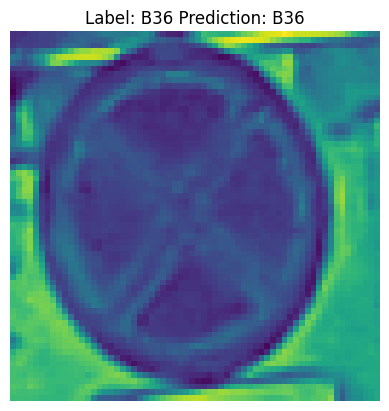

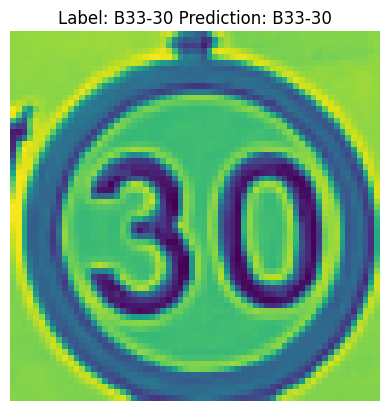

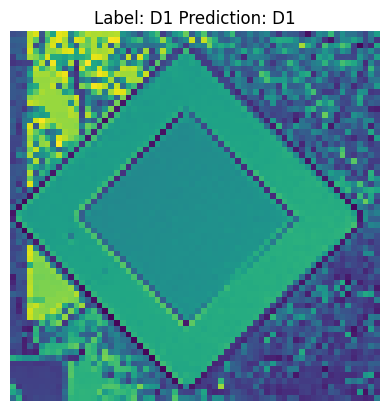

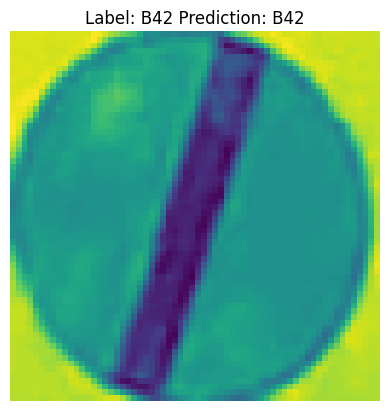

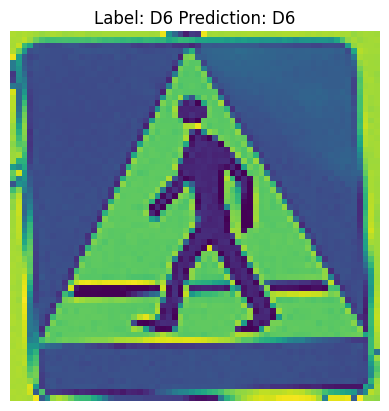

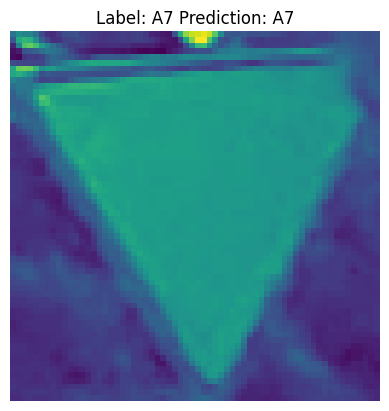

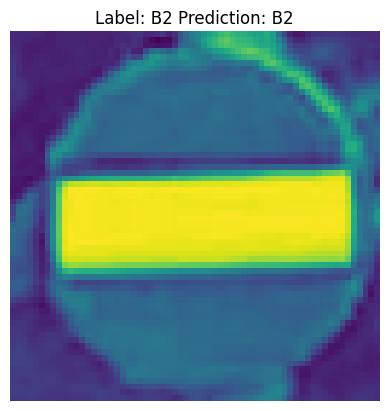

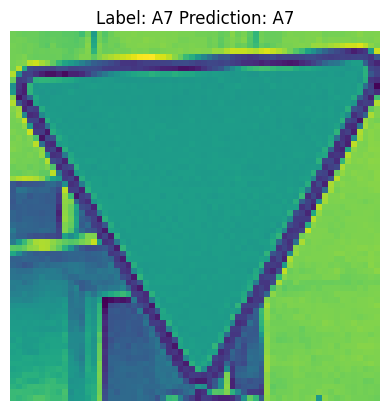

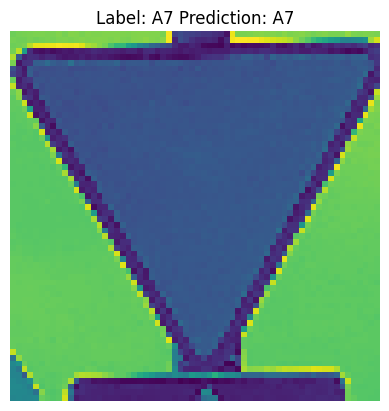

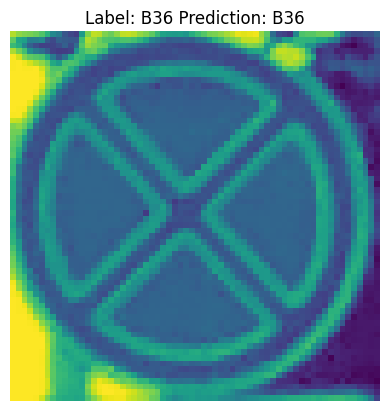

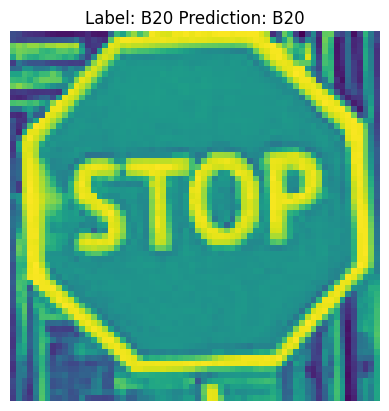

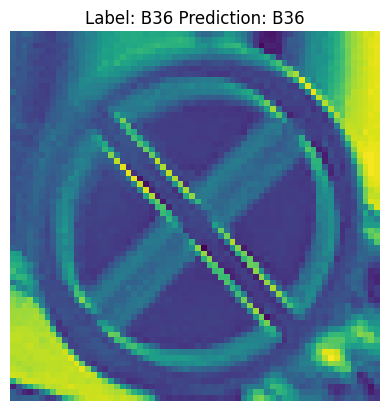

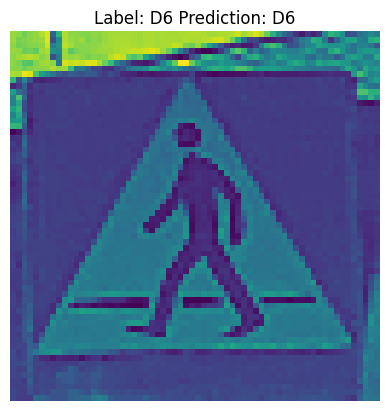

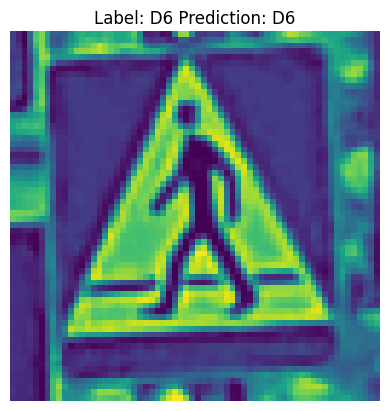

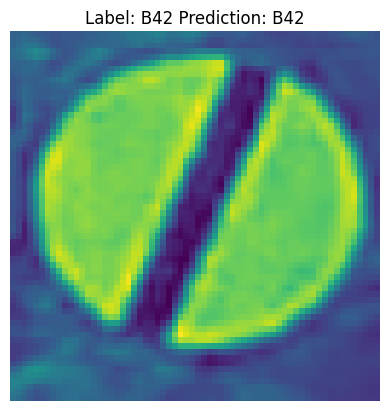

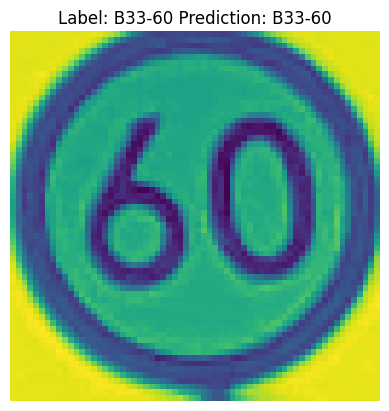

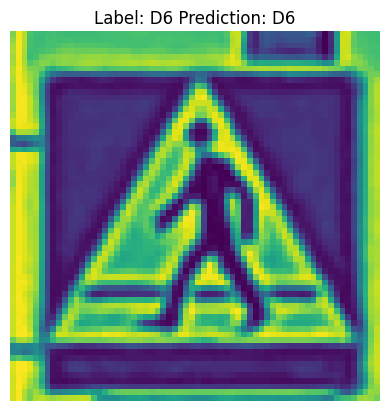

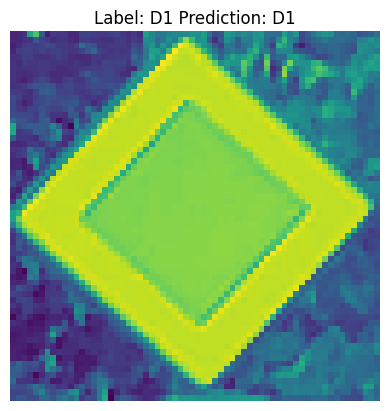

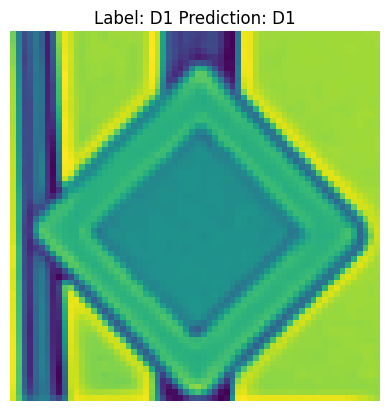

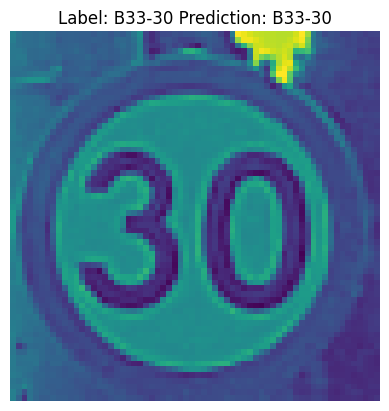

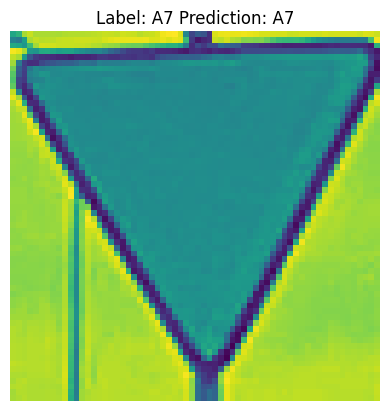

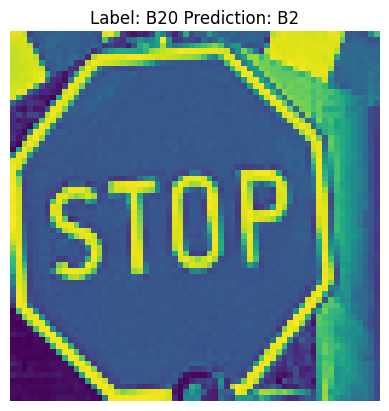

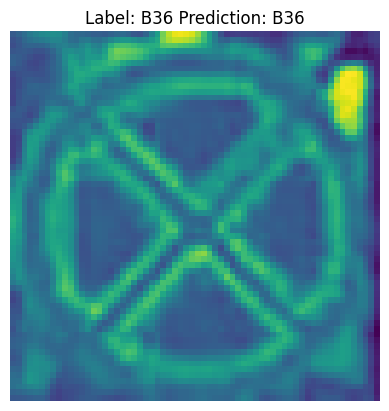

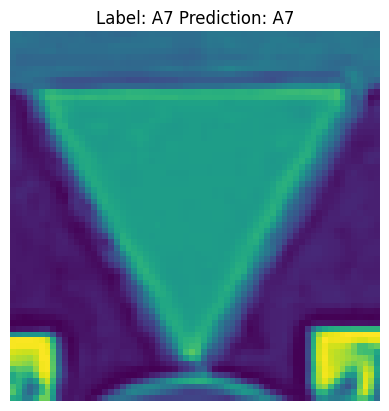

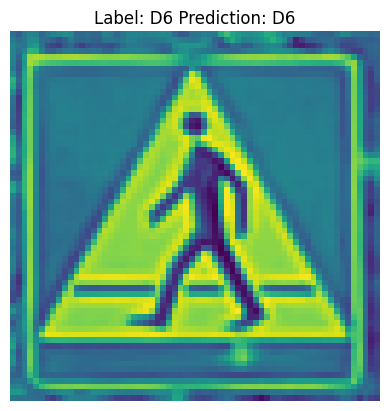

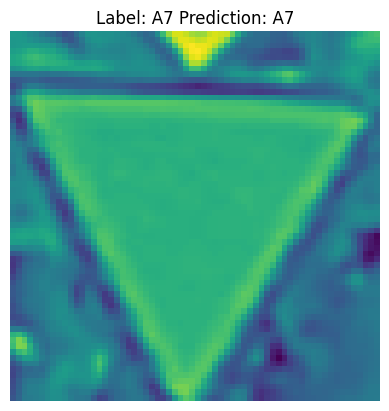

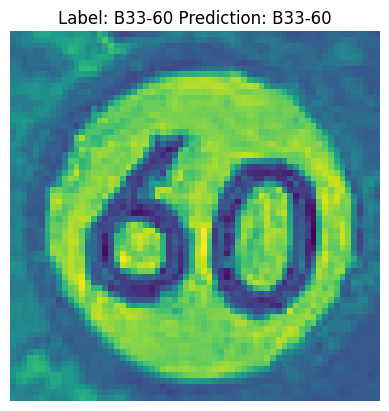

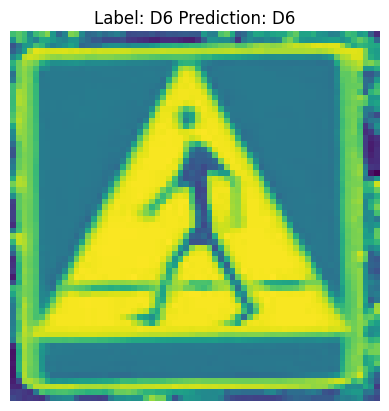

In [11]:
image_batch = test_ds.take(1)
# print(image_batch)
# predictions = model.predict(image_batch)
# print(predictions)
# print(np.argmax(predictions, axis = 1))
y_test = []
x_test = []
for images, labels in image_batch:
    y_test.append(labels)
    x_test.append(images)
# print(images)
# print(labels)
x_test = np.concatenate(x_test)
predictions = model.predict(images)
# print(predictions)
predictions = np.argmax(predictions, axis = 1)
y_test = np.concatenate(y_test)
y_test=np.argmax(y_test, axis=1)
print(y_test)
for i in range(len(y_test)):
    image= x_test[i]
    image = np.clip(image, 0, 255).astype(np.uint8)
    show(image,"Label: "+ str(class_names[y_test[i]]) +" Prediction: " + str(class_names[predictions[i]]))
    # print("Label: ",class_names[y_test[i]], " Prediction: ", class_names[predictions[i]])

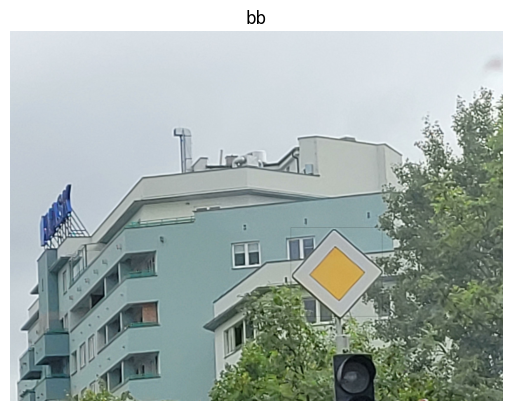

In [19]:
### DETECTION
## Image labelling
# LabelImg App Test

import csv

image = tf.io.read_file('./dataset/detection/108.jpg')
image = tf.io.decode_jpeg(image)
image_batch = tf.expand_dims(image, axis=0)
image_float = tf.image.convert_image_dtype(image_batch, tf.float32)

with open('./dataset/detection/108.csv') as csvfile:
    bounding_boxes = [list(map(float, row)) for row in csv.reader(csvfile, delimiter=',')]
    # bounding_boxes = csv.reader(csvfile, delimiter=',')
    # for box in bounding_boxes:
    #     print(box)
# box = [float(i) for i in box]
box = bounding_boxes[0]
box = np.array([box[1],box[0],box[3],box[2]])
boxes = box.reshape([1, 1, 4])
# alternate between red and blue
colors = np.array([[0.0, 0.0, 0.0]])
image_with_bb = tf.image.draw_bounding_boxes(image_float, boxes, colors)
show(image_with_bb[0], 'bb')
        


In [57]:
data_augmentation_det = tf.keras.Sequential([
    keras.layers.RandomBrightness((-0.05,0.05)), # +-5%
    keras.layers.RandomContrast(0.05), # +-5%
    keras.layers.GaussianNoise(2.5), # 95% of samples fall between -2 * st_dev and +2 * st_dev => [-5; +5]
])

model_det = keras.models.Sequential([
    data_augmentation_det,
    keras.layers.Resizing(64, 64),
    keras.layers.Rescaling(1./255,input_shape=(64, 64, 1)),
    keras.layers.Conv2D(128, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    # keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4)
])

model_det.compile(loss="mse",
 optimizer="sgd",
 metrics=["accuracy"], run_eagerly=True)

In [54]:
def get_img_lbl_det(file_path):
    # print(file_path)
    # filename = tf.strings.split(file_path, os.path.sep)[-1]
    # print(filename)
    # # filename_str = filename.as_string()
    # # print(filename_str)
    # filename = pathlib.Path(filename).stem + '.csv'
    # with open(str(data_dir/filename)) as csvfile:
    #     bounding_boxes = [list(map(float, row)) for row in csv.reader(csvfile, delimiter=',')]
    # box = bounding_boxes[0]
    # label = box
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)
    # img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [64, 64])

    # filename = tf.strings.split(file_path, os.path.sep)[-1]
    filename = tf.strings.regex_replace(file_path, '.jpg', '.csv')
    # label_path = os.path.join(data_dir, filename)
    label = tf.io.read_file(filename)
    label = tf.strings.split(label, sep=',')
    label = tf.strings.to_number(label, out_type=tf.float32)
    return img, label

In [55]:
data_dir = pathlib.Path("./dataset/detection/train")
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
# class_names = np.array(sorted([item.name for item in data_dir.glob('[A-D]*')]))
# print(class_names)
list_ds = list_ds.repeat(5) 
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
# train_ds = train_ds.map(lambda x: tf.py_function(get_img_lbl_det, [x], [tf.string]))
train_ds = train_ds.map(get_img_lbl_det, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(get_img_lbl_det, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(lambda x: tf.py_function(get_img_lbl_det, [x], [tf.string]))
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# for one_element in train_ds:
#     print(one_element)
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

310
1550
1240
310
Image shape:  (32, 64, 64, 1)
Label:  [[0.31       0.07552474 0.42833334 0.2221316 ]
 [0.26       0.04442586 0.46166667 0.31098104]
 [0.45       0.00888889 0.73333335 0.43555555]
 [0.01       0.29103062 0.10166667 0.402111  ]
 [0.41       0.2355048  0.61833334 0.4954488 ]
 [0.36833334 0.38881463 0.425      0.5132353 ]
 [0.50166667 0.33777776 0.6066667  0.46888888]
 [0.56333333 0.8330701  0.695      0.98191196]
 [0.49666667 0.4153844  0.705      0.7441378 ]
 [0.66833335 0.5754557  0.775      0.802083  ]
 [0.425      0.0444629  0.56       0.21564507]
 [0.08       0.03333969 0.245      0.25338167]
 [0.37166667 0.45346376 0.44       0.5446011 ]
 [0.56166667 0.10449574 0.81333333 0.43132284]
 [0.395      0.27333334 0.49       0.4511111 ]
 [0.16833334 0.04       0.42666668 0.41777778]
 [0.42666668 0.51791805 0.50166667 0.6112766 ]
 [0.36166668 0.29157615 0.635      0.65660274]
 [0.27166668 0.7090603  0.475      0.9691231 ]
 [0.06166667 0.25777778 0.19       0.4511111 ]
 [0.

In [58]:
history = model_det.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
39/39 [==============================] - 60s 1s/step - loss: 0.1677 - accuracy: 0.3524 - val_loss: 0.0688 - val_accuracy: 0.4774
Epoch 2/10
39/39 [==============================] - 57s 1s/step - loss: 0.0870 - accuracy: 0.4202 - val_loss: 0.0549 - val_accuracy: 0.4839
Epoch 3/10
39/39 [==============================] - 60s 2s/step - loss: 0.0798 - accuracy: 0.4323 - val_loss: 0.0535 - val_accuracy: 0.4677
Epoch 4/10
39/39 [==============================] - 58s 1s/step - loss: 0.0761 - accuracy: 0.4355 - val_loss: 0.0546 - val_accuracy: 0.4677
Epoch 5/10
39/39 [==============================] - 60s 2s/step - loss: 0.0709 - accuracy: 0.4766 - val_loss: 0.0523 - val_accuracy: 0.5065
Epoch 6/10
39/39 [==============================] - 58s 1s/step - loss: 0.0691 - accuracy: 0.4613 - val_loss: 0.0529 - val_accuracy: 0.4839
Epoch 7/10
39/39 [==============================] - 60s 2s/step - loss: 0.0706 - accuracy: 0.4645 - val_loss: 0.0536 - val_accuracy: 0.4677
Epoch 8/10
39/39 [==

In [59]:
model_det.save('model_mono_det_10.keras')

In [ ]:
model_det = tf.keras.models.load_model('model_mono_det_10.keras')

In [79]:
import cv2

def draw_bb(image_float, box, title):
    image_np = image_float.numpy()
    image_np = np.squeeze(image_np, axis=0)
    # print(image_np.shape)

    height, width, _ = image_np.shape
    
    y_min, x_min, y_max, x_max = box
    
    x_min_pixel = int(x_min * width)
    y_min_pixel = int(y_min * height)
    x_max_pixel = int(x_max * width)
    y_max_pixel = int(y_max * height)
    thickness = 5
    image_with_bb = cv2.rectangle(image_np, (x_min_pixel, y_min_pixel), (x_max_pixel, y_max_pixel), (0, 0, 0), thickness)
    show(image_with_bb, title)

1/1 [==============================] - 0s 48ms/step
[[0.3852343  0.38135266 0.5587129  0.5763557 ]]
tf.Tensor([0.57       0.5311111  0.755      0.77111113], shape=(4,), dtype=float32)


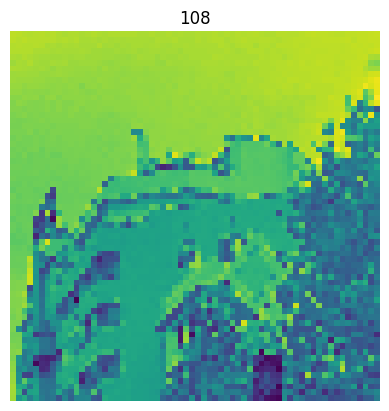

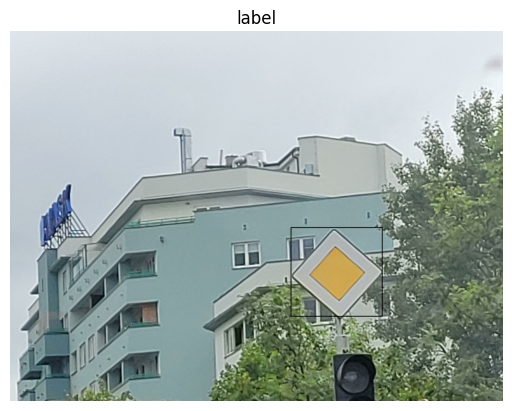

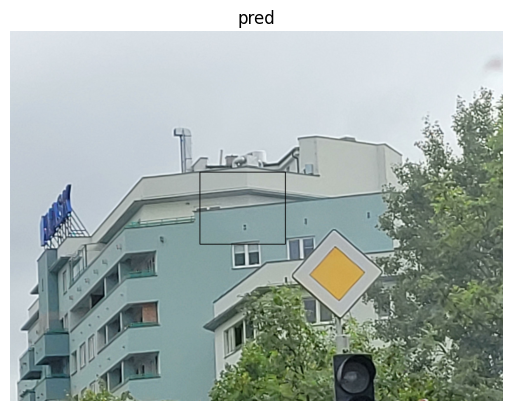

In [87]:
file = "108"
image = tf.io.read_file(file+".jpg")
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, [64, 64])

image_batch = tf.expand_dims(image, axis=0)
predictions = model_det.predict(image_batch)
print(predictions)

label = tf.io.read_file(file+".csv")
label = tf.strings.split(label, sep=',')
label = tf.strings.to_number(label, out_type=tf.float32)
print(label)
show(image, file)

image = tf.io.read_file(file+".jpg")
image = tf.io.decode_jpeg(image)
image_batch = tf.expand_dims(image, axis=0)
image_float = tf.image.convert_image_dtype(image_batch, tf.float32)

with open(file+".csv") as csvfile:
    bounding_boxes = [list(map(float, row)) for row in csv.reader(csvfile, delimiter=',')]
box = bounding_boxes[0]
box = np.array([box[1],box[0],box[3],box[2]])
draw_bb(image_float,box,'label')
# boxes = box.reshape([1, 1, 4])
# colors = np.array([[0.0, 0.0, 0.0]])
# image_with_bb = tf.image.draw_bounding_boxes(image_float, boxes, colors)
# show(image_with_bb[0], 'bb')

box = predictions[0]
box = np.array([box[1],box[0],box[3],box[2]])
# boxes = box.reshape([1, 1, 4])
# colors = np.array([[0.0, 0.0, 0.0, 1.0]])
# image_with_bb = tf.image.draw_bounding_boxes(image_float, boxes, colors, thickness=2)
# show(image_with_bb[0], 'pred')
draw_bb(image_float,box,'pred')